In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from unidecode import unidecode
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import scale

plt.style.use("seaborn")

BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Datos

In [4]:
df = pd.read_csv(f"{BASE}work_data/matriz_desercion_2_dummy.csv.gz")
df.head()

,valor_arancel,desertor_1,prom_notas_media,cant_becas,dif_ing_ult_mat,edad,misma_region,gen_alu_mujer,tipo_inst_1_institutos_profesionales,region_sede_arica_y_parinacota,...,area_conocimiento_tecnologia,acreditada_carr_no_acreditada,acreditada_inst_no_acreditada,tipo_ensenanza_colegio_otro,tipo_ensenanza_colegio_tp_comercial,tipo_ensenanza_colegio_tp_industrial,tipo_ensenanza_colegio_tp_tecnica,dependencia_colegio_otro,dependencia_colegio_particular_pagado,dependencia_colegio_particular_subvencionado
0,1390000.0,1,6.4,0,0,35,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1850000.0,1,5.5,1,0,31,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,803000.0,0,4.7,0,0,29,1,0,0,0,...,1,1,1,0,0,0,0,0,0,1
3,1690000.0,0,6.0,0,0,29,1,0,1,0,...,1,1,0,0,0,0,0,0,0,0
4,1480000.0,0,6.4,0,0,16,1,1,1,0,...,0,1,0,0,0,0,0,0,0,1


# Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["desertor_1"]), df["desertor_1"], random_state=42, test_size=0.10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((797027, 41), (88559, 41), (797027,), (88559,))

In [6]:
pd.Series(y_train).value_counts("%") * 100

0    75.978731
1    24.021269
Name: desertor_1, dtype: float64

# Modelos

## Regresión Logística

In [7]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
X_resampled.shape

(382912, 41)

In [8]:
pd.Series(y_resampled).value_counts("%") * 100

0    50.0
1    50.0
Name: desertor_1, dtype: float64

In [9]:
rl = LogisticRegressionCV(cv=10, random_state=42).fit(X_resampled, y_resampled)

In [10]:
print(classification_report(y_test, rl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.56      0.66     67178
           1       0.28      0.55      0.37     21381

    accuracy                           0.56     88559
   macro avg       0.54      0.55      0.52     88559
weighted avg       0.67      0.56      0.59     88559



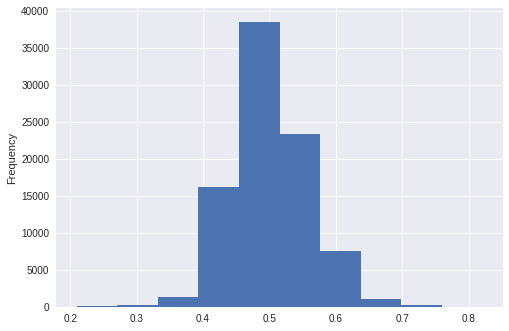

In [11]:
pd.Series(rl.predict_proba(X_test)[:, 1]).plot(kind="hist");

In [12]:
con_proba = df.copy()
con_proba["proba"] = rl.predict_proba(df.drop(columns=["desertor_1"]))[:, 1]

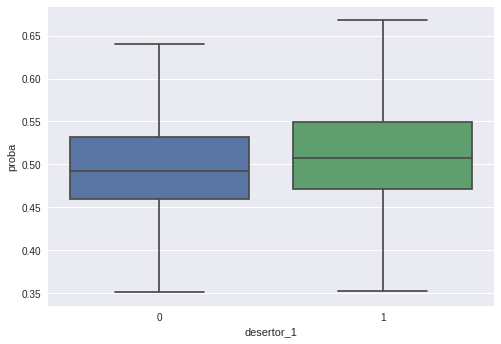

In [13]:
sns.boxplot(data=con_proba, y="proba", x="desertor_1", showfliers=False);

In [93]:
atributos = df.drop(columns=["desertor_1"]).columns
logit_1 = smf.logit(f"desertor_1 ~ {' + '.join(atributos)}", data=df_resampled).fit()
coefs = logit_1.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.637726
         Iterations 5


In [99]:
coefs[(coefs["P>|z|"] < 0.05) & (coefs["Coef."] > 0)].sort_values(by=["Coef."], ascending=False)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,3.285523,0.056489,58.162447,0.000000e+00,3.174807,3.396239
area_conocimiento_arte_y_arquitectura,0.328019,0.016643,19.709199,1.797907e-86,0.295399,0.360638
region_sede_los_lagos,0.310201,0.025411,12.207290,2.841982e-34,0.260396,0.360006
acreditada_inst_no_acreditada,0.290471,0.012807,22.681540,6.816150e-114,0.265371,0.315572
region_sede_magallanes,0.273527,0.044515,6.144602,8.016417e-10,0.186279,0.360774
tipo_ensenanza_colegio_otro,0.270573,0.024072,11.239953,2.595193e-29,0.223392,0.317754
region_sede_arica_y_parinacota,0.252082,0.036052,6.992162,2.706823e-12,0.181421,0.322742
region_sede_lib_gral_b_ohiggins,0.247779,0.025420,9.747311,1.894192e-22,0.197956,0.297601
region_sede_los_rios,0.246903,0.034033,7.254884,4.020049e-13,0.180200,0.313606
region_sede_nuble,0.237460,0.030886,7.688317,1.490831e-14,0.176925,0.297995


In [95]:
coefs[(coefs["P>|z|"] < 0.05) & (coefs["Coef."] < 0)]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
valor_arancel,-5.904945e-08,9.978042e-09,-5.917939,3.260009e-09,-7.860605e-08,-3.949284e-08
prom_notas_media,-6.277222e-01,8.796384e-03,-71.361393,0.000000e+00,-6.449628e-01,-6.104816e-01
cant_becas,-4.610154e-01,7.673192e-03,-60.081308,0.000000e+00,-4.760546e-01,-4.459763e-01
dif_ing_ult_mat,-4.220682e-01,3.548820e-03,-118.932000,0.000000e+00,-4.290238e-01,-4.151127e-01
gen_alu_mujer,-3.004357e-01,8.372686e-03,-35.882836,5.658772e-282,-3.168459e-01,-2.840256e-01
tipo_inst_1_institutos_profesionales,-1.562658e-01,7.743668e-03,-20.179822,1.472748e-90,-1.714432e-01,-1.410885e-01
area_conocimiento_ciencias_sociales,-1.833713e-01,1.678546e-02,-10.924415,8.810625e-28,-2.162702e-01,-1.504724e-01
area_conocimiento_educacion,-7.687329e-02,1.285236e-02,-5.981261,2.214167e-09,-1.020634e-01,-5.168314e-02
area_conocimiento_salud,-5.579363e-02,1.206553e-02,-4.624216,3.760173e-06,-7.944164e-02,-3.214562e-02
acreditada_carr_no_acreditada,-3.788847e-02,7.684870e-03,-4.930269,8.211667e-07,-5.295054e-02,-2.282640e-02


## DT

In [35]:
dt = DecisionTreeClassifier(random_state=42).fit(X_resampled, y_resampled)
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.63      0.72     67178
           1       0.35      0.62      0.45     21381

    accuracy                           0.63     88559
   macro avg       0.59      0.63      0.58     88559
weighted avg       0.72      0.63      0.65     88559



In [68]:
def plot_importance(fit_model, feat_names, n=10):
    tmp_importance = fit_model.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1][:n]
    names = [feat_names[i] for i in sort_importance]
    plt.title("Feature importance")
    plt.barh(range(n), list(reversed(tmp_importance[sort_importance])))
    plt.yticks(range(n), list(reversed(names)), rotation=0)
    return names

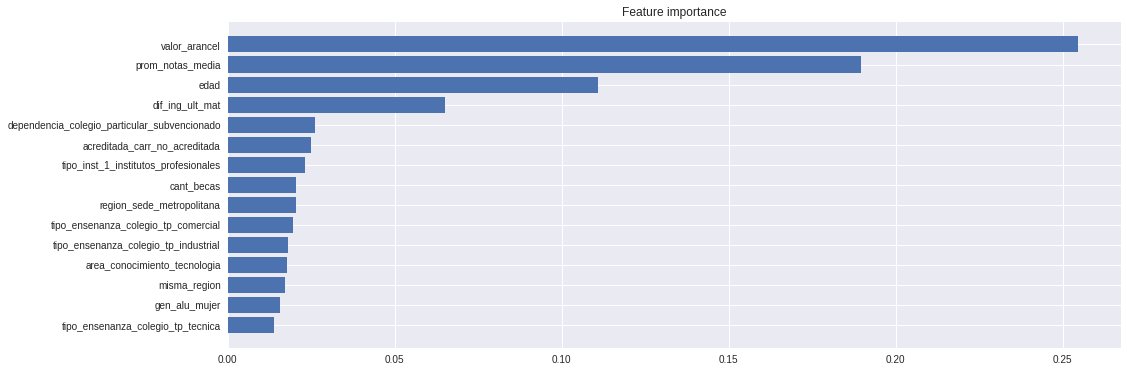

In [69]:
_ = plot_importance(dt, df.drop(columns=["desertor_1"]).columns, n=15)

In [73]:
import xgboost
xgb = xgboost.XGBClassifier().fit(X_resampled, y_resampled)
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.67      0.76     67178
           1       0.41      0.72      0.52     21381

    accuracy                           0.68     88559
   macro avg       0.64      0.69      0.64     88559
weighted avg       0.77      0.68      0.70     88559



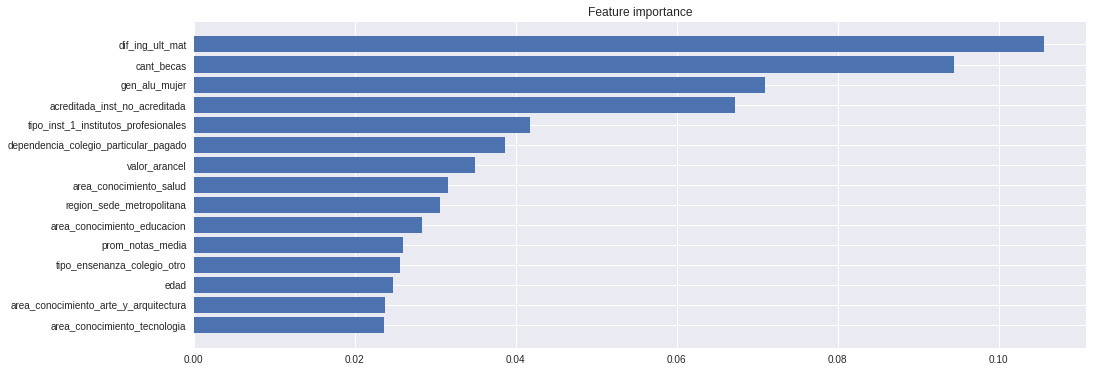

In [77]:
_ = plot_importance(xgb, df.drop(columns=["desertor_1"]).columns, n=15)

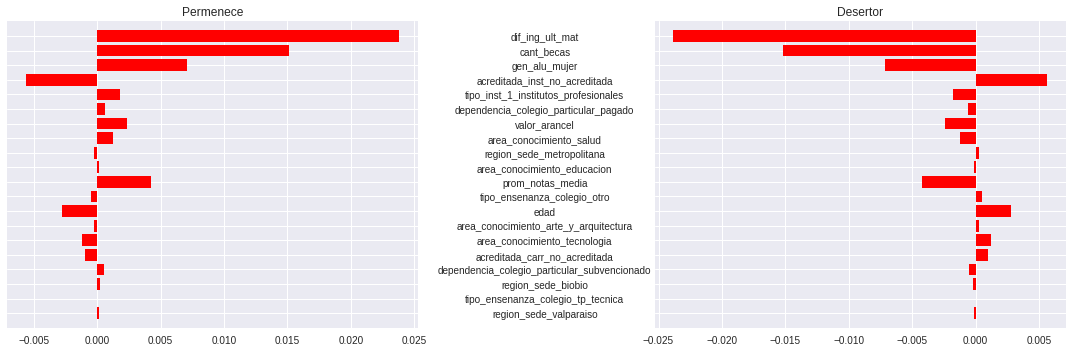

In [148]:
def class_feature_importance(X, Y, feature_importances, n_feats=10):
    sort_importance = np.argsort(feature_importances)[::-1][:n_feats]
    feat_names = X.columns
    names = [feat_names[i] for i in sort_importance]
    importancias = feature_importances[sort_importance]
    
    N, M = X[names].shape
    X = scale(X[names])

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(N), np.mean(X[Y==c, :], axis=0)*importancias)
        )

    return out, names

result, names = class_feature_importance(X_resampled, y_resampled, xgb.feature_importances_, 20)

titles = ["Permenece", "Desertor"]
plt.figure(figsize=(15, 5))
for t, i in zip(titles, range(len(result))):
    ax = plt.subplot(1, 2, i+1)
    plt.title(t)
    plt.barh(
        range(len(result[i])),
        list(reversed(result[i].values())),
        color="r",
        align="center"
    )
    plt.yticks(
        range(len(result[i])),
        list(reversed(np.array(names)[list(result[i].keys())])) if i == 1 else [""] * len(names),
        rotation=0,
        ha="center"
    )
    ax.tick_params(axis='y', which='major', pad=110)
    plt.ylim([-1, len(result[i])])
    
plt.tight_layout()